In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

from skimage.feature import hog
import glob
import time

from sklearn.externals import joblib

%matplotlib inline

In [2]:
# this is our feature map creator (not using Neural Nets)
from feature_engineering import FeatureCreator

In [3]:
# read in some images of cars and not cars to build our classifier
cars = glob.glob('largeset/vehicles/*/*.png')+glob.glob('smallset/vehicles_smallset/*.jpeg')
notcars = glob.glob('largeset/non-vehicles/*/*.png')+glob.glob('./smallset/non-vehicles_smallset/*.jpeg')

car_imgs = [mpimg.imread(x) for x in cars] + [cv2.flip(mpimg.imread(x),0) for x in cars]
notcar_imgs = [mpimg.imread(x) for x in notcars] + [cv2.flip(mpimg.imread(x),0) for x in notcars]

In [9]:
"""
X = np.vstack((car_imgs, notcar_imgs)).astype(np.float64)
y = np.zeros(len(car_imgs)+len(notcar_imgs))
y[:len(car_imgs)] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# if you wanted to use a CNN, you would replace
# the framework with what is here. 
# FeatureCreator converts an image to set of feature maps
model = Pipeline([
    ('create_feats', FeatureCreator()), 
    ('scaler', StandardScaler()),
    ('linear svm', LinearSVC())])

model.fit(X_train, y_train)
joblib.dump(model, 'model_minimal.pkl') 
"""

# load a model assuming it is already built
model = joblib.load('model_minimal.pkl') 

yhat_train = model.predict(X_train)
metric = accuracy_score(y_train, yhat_train)
print("Accuracy Train Rate: {}".format(metric))

yhat_test = model.predict(X_test)
metric = accuracy_score(y_test, yhat_test)
print("Accuracy Test Rate: {}".format(metric))

Accuracy Train Rate: 0.9633977163589799
Accuracy Test Rate: 0.9394970536974023


Now that we have a model built, we will concentrate on the object detection problem. 

The gist of the problem:

1.  Construct a series fo sliding windows over an image
    *  These could be (should be) of different sizes
2.  Based on the sliding images, construct a heatmap
    *  "Learn" or label images based on some threshold of how "hot" a box is
3.  Over a collection of "hot" boxes, construct a bounding box

In [48]:
from heat_boxes import *

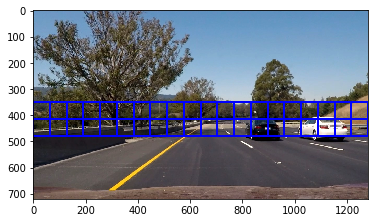

In [14]:
image = mpimg.imread("test_images/test6.jpg")
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.0, 0.0))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

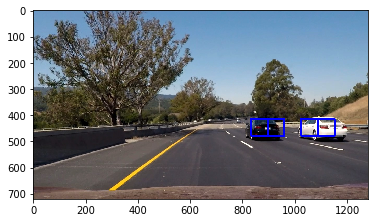

In [13]:
image = mpimg.imread("test_images/test6.jpg")
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.0, 0.0))

hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Now we can put together different size windows to create a heatmap.

From the heatmap scipy image has `label` function to label "clusters".

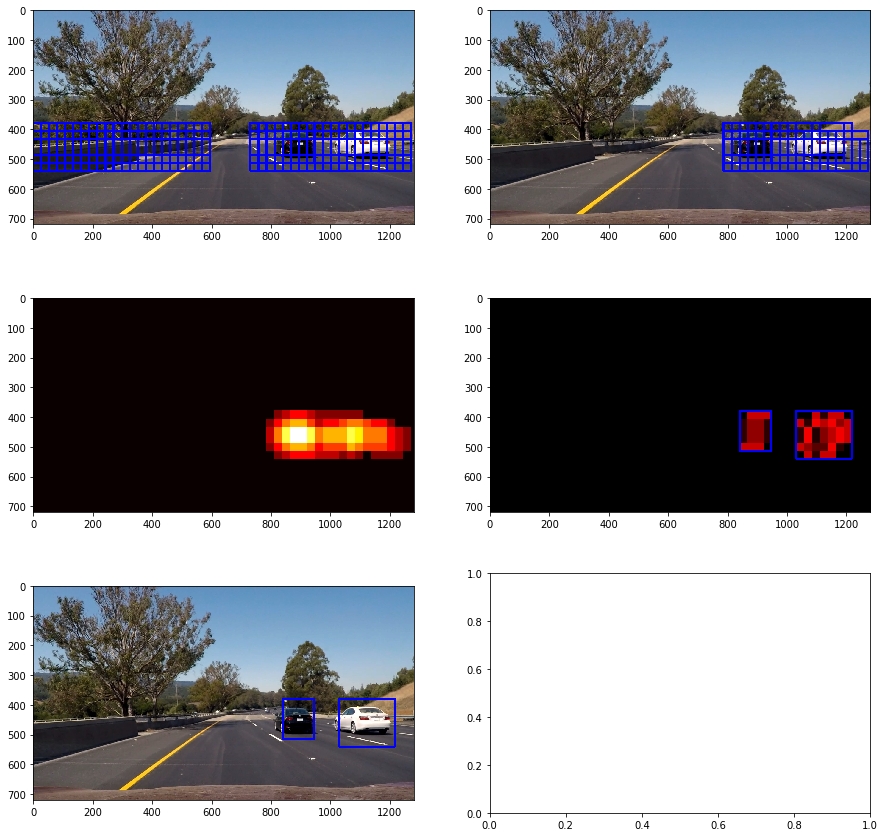

In [47]:
windows = (slide_window(image, x_start_stop=[730, 1280], y_start_stop=[380, 550], 
                       xy_window=(108, 108), xy_overlap=(0.75, 0.75))+
           slide_window(image, x_start_stop=[0, 600], y_start_stop=[380, 550], 
                       xy_window=(108, 108), xy_overlap=(0.75, 0.75)))


hot_windows = search_windows_pipeline(image, windows, model)  
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

labels = label(heatmap)
heatmap_col = cv2.cvtColor(heatmap*100,cv2.COLOR_GRAY2RGB)
heatmap_col[:, :, 1] = 0
heatmap_col[:, :, 2] = 0
draw_img = draw_labeled_bboxes(heatmap_col, labels)
draw_baseimg = draw_labeled_bboxes(image, labels)

_, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0][0].imshow(draw_boxes(image, windows, color=(0, 0, 255), thick=6))
ax[0][1].imshow(draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6))
ax[1][0].imshow(create_heatmap(image, hot_windows, 1), cmap='hot')
ax[1][1].imshow(draw_img)
ax[2][0].imshow(draw_baseimg)


In [ ]:
test_out_file = 'project_video_20170815_v3.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(0, 8)
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_20170815_v3.mp4
[MoviePy] Writing video project_video_20170815_v3.mp4


 45%|███████████████████████████████████▉                                           | 573/1261 [02:30<03:02,  3.78it/s]

In [40]:
#test_out_file = 'test_video_20170815_v2.mp4'
#clip_test = VideoFileClip('test_video.mp4')
#clip_test_out = clip_test.fl_image(process_image)
#%time clip_test_out.write_videofile(test_out_file, audio=False)

In [39]:
# remove false positives...
# make use of global

heat_old = np.zeros((720, 1280))

def process_image(image, model=model):
    global heat_old    
    
    # process everything based on the model pipeline used above
    windows = (slide_window(image, x_start_stop=[730, 1280], y_start_stop=[380, 550], 
                           xy_window=(96, 96), xy_overlap=(0.75, 0.75)))
    xss = [730, 1280]
    
    xss1 = [0, 550] # in these examples there is nothing on that realm. # this is cheating a bit    
    #xss1 = [0, 0] # cheating
    yss = [380, 550]
    windows = (
#slide_window(image, x_start_stop=xss, y_start_stop=yss, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)) +
          slide_window(image, x_start_stop=xss, y_start_stop=yss, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7)) 
#slide_window(image, x_start_stop=xss1, y_start_stop=yss, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)) +
#          slide_window(image, x_start_stop=xss1, y_start_stop=yss, 
#                    xy_window=(96, 96), xy_overlap=(0.7, 0.7)) +
#slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
#                    xy_window=(128, 128), xy_overlap=(0.6, 0.6)) +
#slide_window(image, x_start_stop=xss, y_start_stop=yss, 
#                    xy_window=(192, 192), xy_overlap=(0.7, 0.7)) +
#slide_window(image, x_start_stop=[1000, None], y_start_stop=[400, 720], 
#                        xy_window=(256, 256), xy_overlap=(0.8, 0.8)) +
#              slide_window(image, x_start_stop=[0, 280], y_start_stop=[400, 720], 
#                        xy_window=(256, 256), xy_overlap=(0.8, 0.8))
)
    
    windows = (slide_window(image, x_start_stop=[730, 1280], y_start_stop=[380, 550], 
                           xy_window=(96, 96), xy_overlap=(0.75, 0.75)))


    hot_windows = search_windows_pipeline(image, windows, model)  
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

    # lets draw head boxes...    
    
    heat = np.zeros_like(image[:,:,0])
    heat = add_heat(heat, hot_windows)    
    
    heat_ = heat_old + heat
    heat_old = heat
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat_, 5)    
    
    
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    return draw_img